In [29]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt

In [30]:
# データを読み込む
data_dir = '../Mining_DATA/Formatted_DATA/'

# AAPL.csvを読み込む
aapl_path = os.path.join(data_dir, 'AAPL.csv')
aapl_data = pd.read_csv(aapl_path)
aapl_data = aapl_data[['Date', 'Open']]

# AAPL.csv以外のcsvファイルのリストを取得
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and f != 'AAPL.csv']

# データフレームのリスト
data_list = []

# 各CSVファイルを読み込み、DateとOpen列を選択
for file in csv_files:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    df = df[['Date', 'Open']]
    # カラム名をユニークにするためにファイル名を追加
    df.rename(columns={'Open': f'Open_{file[:-4]}'}, inplace=True)
    data_list.append(df)

# 他の株のOpen値をマージ
merged_data = aapl_data
for df in data_list:
    merged_data = pd.merge(merged_data, df, on='Date', how='inner')

# 日付でソート
merged_data.sort_values('Date', inplace=True)

# 欠損値の処理
merged_data.dropna(inplace=True)

# 特徴量と目的変数の設定
X = merged_data.drop(columns=['Date', 'Open'])
y = merged_data['Open']

# 過去30日分のデータを使用してシーケンスを作成
window_size = 30

def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X.iloc[i-window_size:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

# シーケンスを作成
X_seq, y_seq = create_sequences(X, y, window_size)

# データをtrainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# データを標準化
scaler = StandardScaler()
# 訓練データの形状を保存
X_train_shape = X_train.shape
# 2次元に変換してスケーリング
X_train = X_train.reshape(-1, X_train.shape[2])
X_train = scaler.fit_transform(X_train)
X_train = X_train.reshape(X_train_shape)

X_test_shape = X_test.shape
X_test = X_test.reshape(-1, X_test.shape[2])
X_test = scaler.transform(X_test)
X_test = X_test.reshape(X_test_shape)

# LSTMモデルの作成
model = Sequential()

# 1つ目のLSTM層
model.add(LSTM(
    128, 
    return_sequences=True, 
    input_shape=(X_train.shape[1], X_train.shape[2]),
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001)
))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# 2つ目のLSTM層
model.add(LSTM(
    256, 
    return_sequences=True,
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001)
))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# 3つ目のLSTM層
model.add(LSTM(
    512, 
    return_sequences=True,
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001)
))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# 4つ目のLSTM層
model.add(LSTM(
    256, 
    return_sequences=True,
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001)
))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# 5つ目のLSTM層
model.add(LSTM(
    128, 
    return_sequences=True,
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001)
))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# 6つ目のLSTM層（最後のLSTM層はreturn_sequences=False）
model.add(LSTM(
    64, 
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001)
))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# 出力層
model.add(Dense(1))

# モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# 早期停止のコールバックを設定
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# モデルの学習
history = model.fit(
    X_train,
    y_train,
    epochs=10000,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)

# 予測
y_pred = model.predict(X_test)

# 精度評価
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Epoch 1/10000
197/197 [==============================] - 18s 46ms/step - loss: 188.5469 - val_loss: 1530.1893
Epoch 2/10000
197/197 [==============================] - 7s 36ms/step - loss: 149.8506 - val_loss: 1424.0861
Epoch 3/10000
197/197 [==============================] - 7s 36ms/step - loss: 139.3215 - val_loss: 1413.7045
Epoch 4/10000
197/197 [==============================] - 7s 36ms/step - loss: 129.1199 - val_loss: 1435.3224
Epoch 5/10000
197/197 [==============================] - 7s 35ms/step - loss: 119.9690 - val_loss: 1410.6436
Epoch 6/10000
197/197 [==============================] - 7s 35ms/step - loss: 112.0845 - val_loss: 1339.7581
Epoch 7/10000
197/197 [==============================] - 7s 36ms/step - loss: 103.6781 - val_loss: 1180.8099
Epoch 8/10000
197/197 [==============================] - 7s 37ms/step - loss: 95.7180 - val_loss: 1137.5627
Epoch 9/10000
197/197 [==============================] - 7s 36ms/step - loss: 87.8128 - val_loss: 1093.5739
Epoch 10/10000
197/1

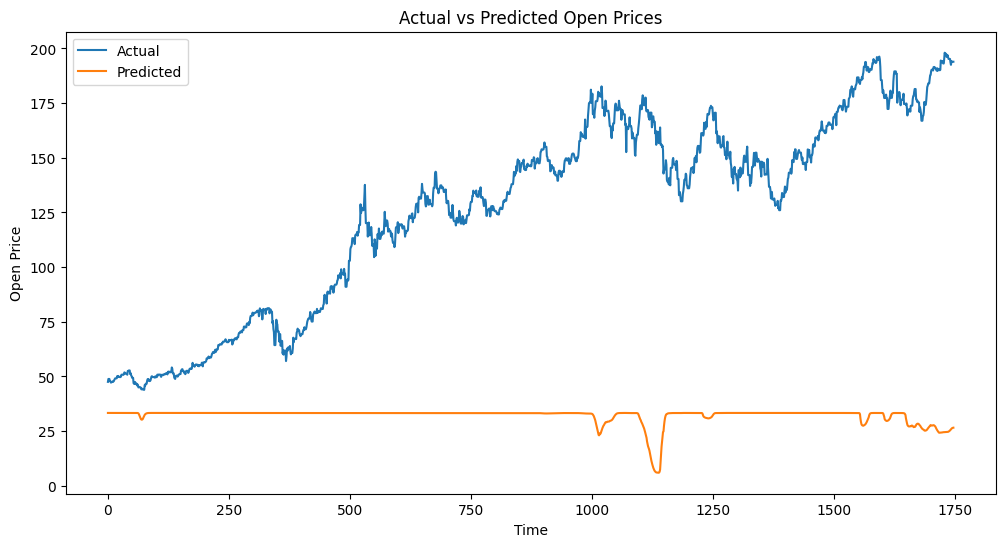

In [33]:
import matplotlib.pyplot as plt

# 予測結果と実際の値をプロット
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.title('Actual vs Predicted Open Prices')
plt.legend()
plt.show()

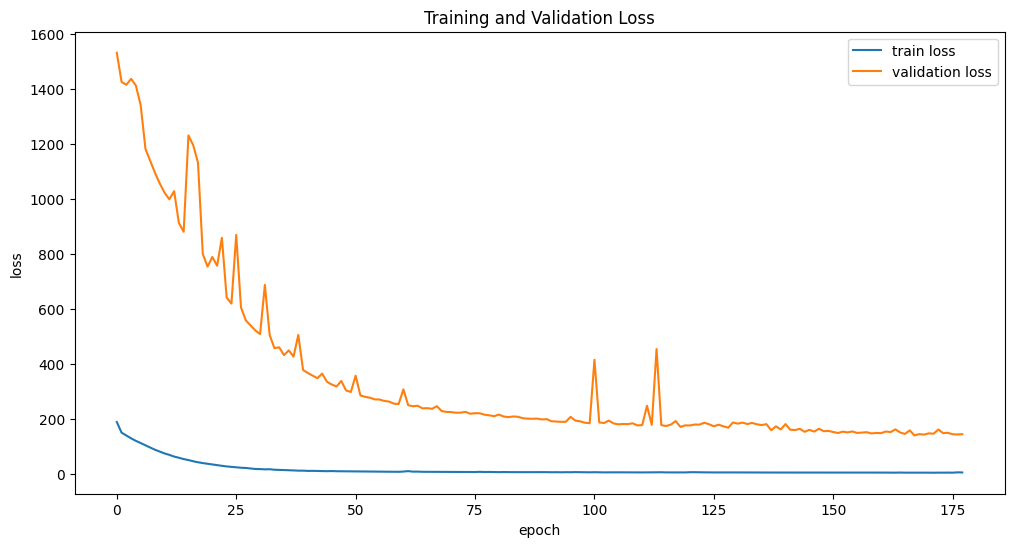

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()